In [1]:
%matplotlib inline
from fastai.vision.all import *
import pandas as pd
import numpy as np
from PIL import Image
import glob
import os

In [2]:
home_folder = os.getcwd()
path = Path("SampleMoviePosters")/"SampleMoviePosters"
fns = get_image_files(path)
cam_fn = fns[0]
str(cam_fn)[str(cam_fn).rfind("/")+1:-4]

'19071'

In [3]:
data_file = os.path.join(home_folder,"MovieGenre.csv")
df=pd.read_csv(data_file, encoding='latin-1',index_col=False).dropna().drop_duplicates()
df.head(5)

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,"https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_UX182_CR0,0,182,268_AL_.jpg"
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,"https://images-na.ssl-images-amazon.com/images/M/MV5BZTk2ZmUwYmEtNTcwZS00YmMyLWFkYjMtNTRmZDA3YWExMjc2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UY268_CR10,0,182,268_AL_.jpg"
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMjQxM2YyNjMtZjUxYy00OGYyLTg0MmQtNGE2YzNjYmUyZTY1XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTczMTMyMTgyM15BMl5BanBnXkFtZTcwOTc4OTQyMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BOTEyNzg5NjYtNDU4OS00MWYxLWJhMTItYWU4NTkyNDBmM2Y0XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"


In [5]:
posters = df["Poster"]
posters = posters.dropna()
posters = pd.DataFrame(posters)
output_csv = os.path.join(home_folder, 'out.csv')
images=posters.to_csv(output_csv,sep=',', index = False)

In [6]:
df['First Genre'] = df['Genre'].str.split('|') .str.get(0)
idtogenre = df[["imdbId","First Genre"]]
genre_list= idtogenre["First Genre"].unique()
idtogenre.head(5)

,imdbId,First Genre
0,114709,Animation
1,113497,Action
2,113228,Comedy
3,114885,Comedy
4,113041,Comedy


In [7]:
print(genre_list)
genre_dir = path
def create_genre_dir(genres):
    for genre in genres:
        path = os.path.join(genre_dir, genre) 
        if not os.path.exists(path):
            os.makedirs(path) 
create_genre_dir(genre_list)

['Animation' 'Action' 'Comedy' 'Adventure' 'Biography' 'Crime' 'Drama'
 'Fantasy' 'Mystery' 'Romance' 'Sci-Fi' 'Documentary' 'Family' 'Horror'
 'Thriller' 'Musical' 'Short' 'Western' 'Film-Noir' 'War' 'Music'
 'Talk-Show' 'History' 'Adult' 'Sport']


In [8]:
def file_id_list(filenames):
    array = []
    for file in filenames:
        file = str(file)[str(file).rfind("/")+1:-4]
        array.append(file)
file_id_list(fns)

In [14]:
def file_sorting(folder,csv):
    for file in folder:
        if os.path.exists(file):
            str(file)
            filename = str(file)[str(file).rfind("/")+1:-4]
            found = idtogenre.loc[idtogenre["imdbId"]==int(filename)]["First Genre"].item()
            shutil.move(file, os.path.join(home_folder, "SampleMoviePosters/SampleMoviePosters/", found,filename+".jpg"))

In [15]:
file_sorting(fns,idtogenre)

In [16]:
movies = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [17]:
dls = movies.dataloaders(path)
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

/home/jab/.pyenv/versions/3.9.4/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/jab/.pyenv/versions/3.9.4/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,4.589374,3.679424,0.889447,00:01


epoch,train_loss,valid_loss,error_rate,time
0,3.911642,3.423209,0.894472,00:02
1,3.679727,3.196282,0.844221,00:02
2,3.341420,3.072363,0.773869,00:02
3,2.882123,3.136848,0.753769,00:02
4,2.445569,3.384056,0.733668,00:02
5,2.041142,3.297611,0.753769,00:02
6,1.692097,3.273211,0.753769,00:02
7,1.411717,3.277529,0.718593,00:02
8,1.173182,3.288692,0.713568,00:02
9,0.993591,3.281056,0.708543,00:02


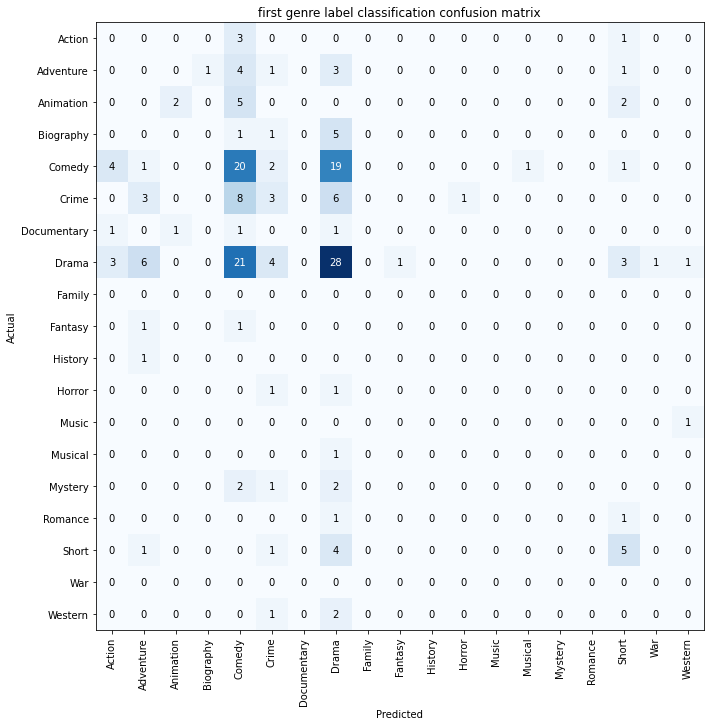

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title="first genre label classification confusion matrix",figsize=(10,10))
